# Overview

- The goal of this notebook is to experiment with non parametric machine learning models.  
- These models make no assumptions about the scaling of the data and require minimal preprocessing.  
    - However, they are prone to overfitting.  
- I use a relatively small dataset with a mix of continuous and categorical features where the only preprocessing is to use One-Hot Encoding on the categorical features.  The small dataset with multiple features will be likely to overfitting with no intervention
- We will examine overfitting behavior and explain how we can reduce it

Table of contents
=================

<!--ts-->
   * [ImportPackagesAndData](#ImportPackagesAndData)
   * [ExploratoryAnalysis](#ExploratoryAnalysis) 
   * [ModelFitting](#ModelFitting)
       * [DecisionTree](#DecisionTree) 
       * [RandomForest](#RandomForest) 
       * [ADABOOST](#ADABOOST) 


## ImportPackagesAndData


### Dataset
https://archive.ics.uci.edu/ml/datasets/heart+disease
This dataset is freely available courtesy of UC Irive Machine Learning Repository

### Features 

Age : displays the age of the individual.

Sex : displays the gender of the individual using the following format : 1 = male 0 = female.

Chest-pain type : displays the type of chest-pain experienced by the individual using the following format : 1 = typical angina 2 = atypical angina 3 = non - anginal pain 4 = asymptotic

Resting Blood Pressure : displays the resting blood pressure value of an individual in mmHg (unit)

Serum Cholestrol : displays the serum cholestrol in mg/dl (unit)

Fasting Blood Sugar : compares the fasting blood sugar value of an individual with 120mg/dl. If fasting blood sugar > 120mg/dl then : 1 (true) else : 0 (false)

Resting ECG : 0 = normal 1 = having ST-T wave abnormality 2 = left ventricular hyperthrophy

Max heart rate achieved : displays the max heart rate achieved by an individual.

Exercise induced angina : 1 = yes 0 = no

ST depression induced by exercise relative to rest : displays the value which is integer or float.

Peak exercise ST segment : 1 = upsloping 2 = flat 3 = downsloping

Number of major vessels (0-3) colored by flourosopy : displays the value as integer or float.

Thal : displays the thalassemia : 3 = normal 6 = fixed defect 7 = reversable defect

Diagnosis of heart disease : Displays whether the individual is suffering from heart disease or not : 0 = absence 1,2,3,4 = present.

In [1]:
import pandas as pd
import numpy as np

In [2]:

data_path = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_data = pd.read_csv(data_path, delimiter = ",", header=None)
heart_data = heart_data.replace({'?':np.NaN})
heart_data.columns = ['age', 'sex', 'cp', 'trestbps', 'chol',
              'fbs', 'restecg', 'thalach', 'exang', 
              'oldpeak', 'slope', 'ca', 'thal', 'target']
heart_data['target'] = heart_data.target.map({0: 0, 1: 1, 2: 1, 3: 1, 4: 1})
heart_data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,1
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,1
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


In [3]:
print(heart_data.isna().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64


In [4]:
print(heart_data.nunique())


age          41
sex           2
cp            4
trestbps     50
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            4
thal          3
target        2
dtype: int64


In [5]:
heart_data['thal'] = pd.to_numeric(heart_data['thal'])
heart_data['thal'] = heart_data['thal'].fillna(heart_data['thal'].mean())

heart_data['ca'] = pd.to_numeric(heart_data['ca'])
heart_data['ca'] = heart_data['ca'].fillna(heart_data['ca'].mean())

In [6]:
heart_data['thal'].unique()
#heart_data['ca']

array([6.        , 3.        , 7.        , 4.73421927])

## ExploratoryAnalysis

0    0.541254
1    0.458746
Name: target, dtype: float64

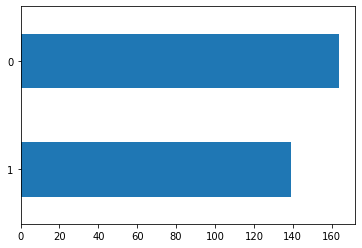

In [7]:
heart_data["target"].value_counts().sort_index(ascending=False).plot(kind='barh')
heart_data["target"].value_counts(normalize=True)

## ModelFitting

In [8]:
import category_encoders as ce
X = heart_data.iloc[:, :-1]
X = ce.OneHotEncoder(use_cat_names=True, cols = ['sex','cp','fbs','restecg','exang','slope','thal']).fit_transform(X)

y = heart_data.iloc[:, -1]


c:\users\bclar\anaconda3\envs\mainenv\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [9]:
X.columns

Index(['age', 'sex_1.0', 'sex_0.0', 'cp_1.0', 'cp_4.0', 'cp_3.0', 'cp_2.0',
       'trestbps', 'chol', 'fbs_1.0', 'fbs_0.0', 'restecg_2.0', 'restecg_0.0',
       'restecg_1.0', 'thalach', 'exang_0.0', 'exang_1.0', 'oldpeak',
       'slope_3.0', 'slope_2.0', 'slope_1.0', 'ca', 'thal_6.0', 'thal_3.0',
       'thal_7.0', 'thal_4.73421926910299'],
      dtype='object')

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2, stratify=y)

### DecisionTree

First, I will examine basic Decision Trees using the CART algorithm

Current model is wrong because it does >,< on categorical variables.  This is nonsense

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

decision_tree = DecisionTreeClassifier(random_state = 42)

param_dict = {
    #"criterion":['gini','entropy'],
    "max_depth":range(1,20)
}


gridDtNoCv = GridSearchCV(decision_tree,
                   param_grid = param_dict,
                   cv=[(slice(None), slice(None))],
                   verbose=1,
                   n_jobs = -1)
gridDtNoCv.fit(X_train,y_train)

gridDtCv = GridSearchCV(decision_tree,
                   param_grid = param_dict,
                   cv=10,
                   verbose=1,
                   n_jobs = -1)

gridDtCv.fit(X_train,y_train)

Fitting 1 folds for each of 19 candidates, totalling 19 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 19 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    0.2s finished


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             n_jobs=-1, param_grid={'max_depth': range(1, 20)}, verbose=1)

In [12]:
print('Best depth with no cross validation: ' + str(gridDtNoCv.best_params_) + ' Score: ' + str(gridDtNoCv.best_score_) )
print('Best depth with cross validation: ' + str(gridDtCv.best_params_) + ' Score: ' + str(gridDtCv.best_score_) )

Best depth with no cross validation: {'max_depth': 11} Score: 1.0
Best depth with cross validation: {'max_depth': 3} Score: 0.7765000000000001


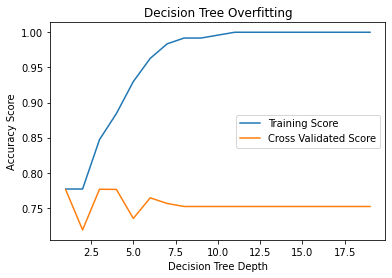

In [13]:
from matplotlib import pyplot as plt

max_depth = []
for i in gridDtNoCv.cv_results_['params']:
    val = sum( i.values() ) 
    max_depth.append(val)

Score_Dt_NoCV = gridDtNoCv.cv_results_['mean_test_score']   
Score_Dt_wCV = gridDtCv.cv_results_['mean_test_score']   


plt.plot(max_depth, Score_Dt_NoCV, label = "Training Score")
plt.plot(max_depth, Score_Dt_wCV, label = "Cross Validated Score")
plt.xlabel('Decision Tree Depth')
# Set the y axis label of the current axis.
plt.ylabel('Accuracy Score')
# Set a title of the current axes.
plt.title('Decision Tree Overfitting')
# show a legend on the plot
plt.legend()
plt.show()

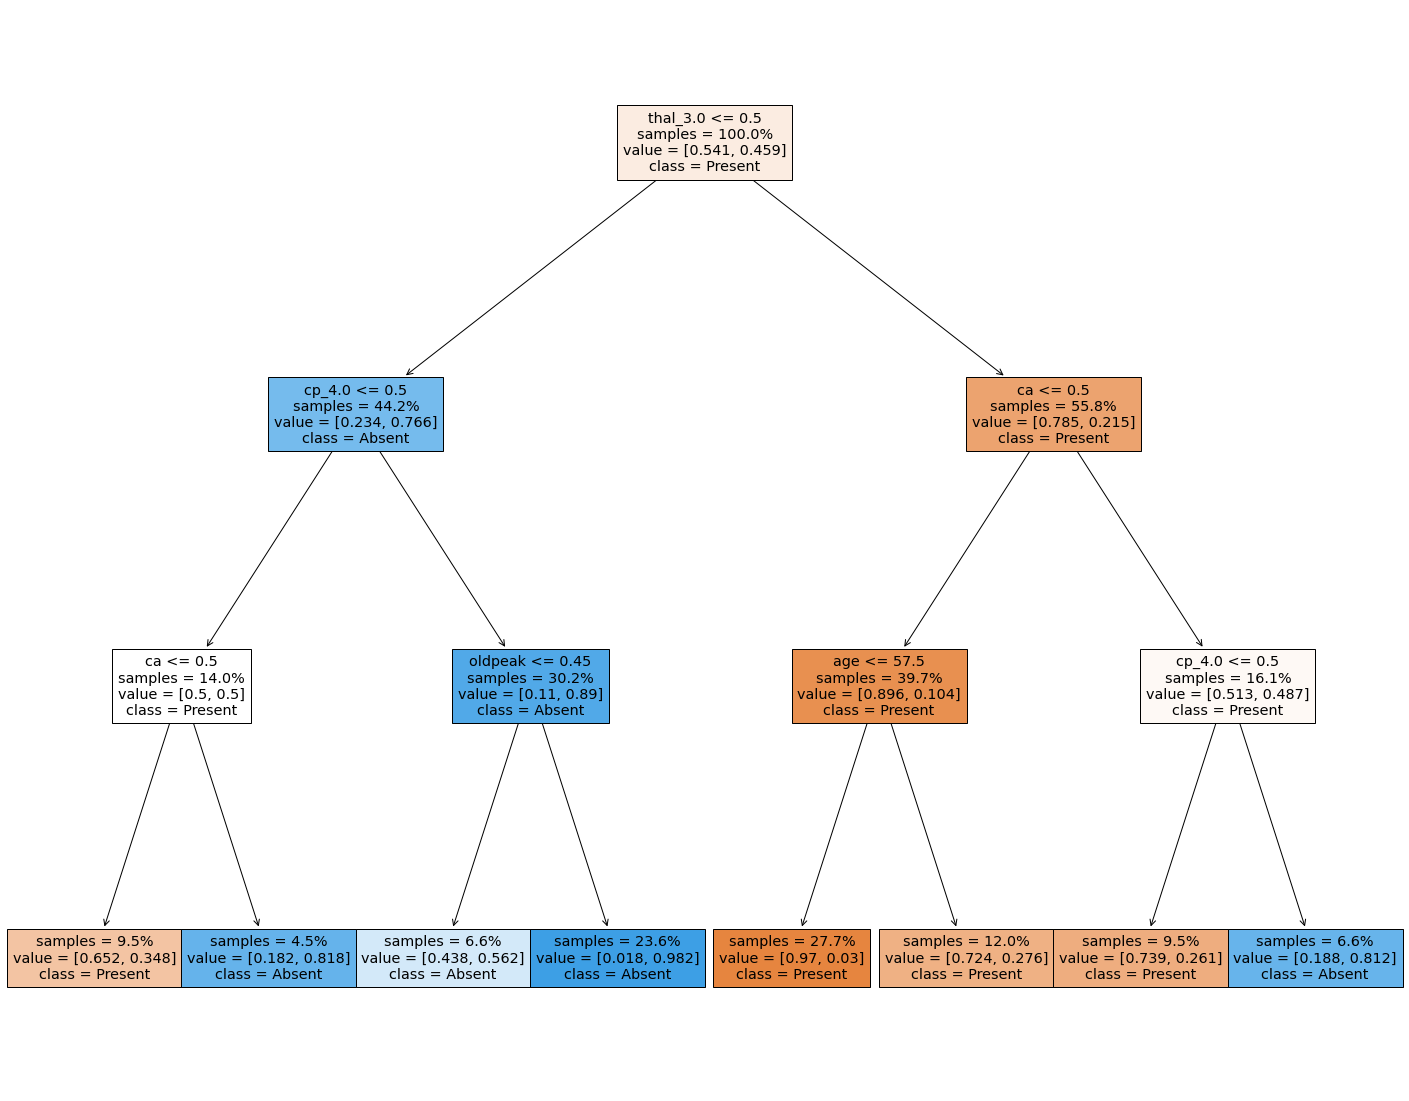

In [14]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(gridDtCv.best_estimator_, 
                   feature_names=X.columns,  
                   class_names=['Present', 'Absent'],
                   filled=True,
                   impurity=False, 
                   proportion=True)

### RandomForest

ensemble of Decision Trees <br>
bagging - sampling with replacement - 63% of points get used <br>
uses subest of features.  Default is sqrt(num features) <br>

In [15]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(
    random_state = 42, 
    n_estimators = 100, 
    bootstrap = True)
random_forest.fit(X_train, y_train)

rf_param_dict = {
    #"criterion":['gini','entropy'],
    #"n_estimators":range(1,50),
    "max_depth":range(1,20)
}


gridRFNoCv = GridSearchCV(random_forest,
                   param_grid = rf_param_dict,
                   cv=[(slice(None), slice(None))],
                   verbose=1,
                   n_jobs = -1)
gridRFNoCv.fit(X_train,y_train)

gridRFCv = GridSearchCV(random_forest,
                   param_grid = rf_param_dict,
                   cv=10,
                   verbose=1,
                   n_jobs = -1)

gridRFCv.fit(X_train,y_train)

Fitting 1 folds for each of 19 candidates, totalling 19 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 19 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    6.4s finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-1, param_grid={'max_depth': range(1, 20)}, verbose=1)

In [16]:
print('Best # of esitmators with no cross validation: ' + str(gridRFNoCv.best_params_) + ' Score: ' + str(gridRFNoCv.best_score_) )
print('Best # of esitmators with cross validation: ' + str(gridRFCv.best_params_) + ' Score: ' + str(gridRFCv.best_score_) )

Best # of esitmators with no cross validation: {'max_depth': 9} Score: 1.0
Best # of esitmators with cross validation: {'max_depth': 3} Score: 0.8173333333333332


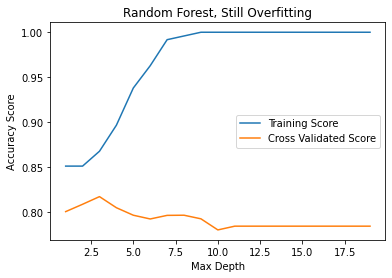

In [17]:
n_estimators = []
for i in gridRFNoCv.cv_results_['params']:
    val = sum( i.values() ) 
    n_estimators.append(val)

Score_RF_NoCV = gridRFNoCv.cv_results_['mean_test_score']   
Score_RF_wCV = gridRFCv.cv_results_['mean_test_score']   


plt.plot(n_estimators, Score_RF_NoCV, label = "Training Score")
plt.plot(n_estimators, Score_RF_wCV, label = "Cross Validated Score")
plt.xlabel('Max Depth')
# Set the y axis label of the current axis.
plt.ylabel('Accuracy Score')
# Set a title of the current axes.
plt.title('Random Forest, Still Overfitting')
# show a legend on the plot
plt.legend()
plt.show()

### ADABOOST

In [18]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    RandomForestClassifier(max_depth = 3), 
    n_estimators = 100,
    random_state = 42, 
    algorithm = "SAMME.R")


ada_param_dict = {
    "learning_rate":np.linspace(.1,1,9,endpoint=False)
}


gridAdaNoCv = GridSearchCV(ada_clf,
                   param_grid = ada_param_dict,
                   cv=[(slice(None), slice(None))],
                   verbose=1,
                   n_jobs = -1)
gridAdaNoCv.fit(X_train,y_train)

gridAdaCv = GridSearchCV(ada_clf,
                   param_grid = ada_param_dict,
                   cv=10,
                   verbose=1,
                   n_jobs = -1)

gridAdaCv.fit(X_train,y_train)

Fitting 1 folds for each of 9 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   27.5s remaining:   34.5s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   30.7s finished


Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.6min finished


GridSearchCV(cv=10,
             estimator=AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=3),
                                          n_estimators=100, random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
             verbose=1)

In [19]:
print('Best # of esitmators with no cross validation: ' + str(gridAdaNoCv.best_params_) + ' Score: ' + str(gridAdaNoCv.best_score_) )
print('Best # of esitmators with cross validation: ' + str(gridAdaCv.best_params_) + ' Score: ' + str(gridAdaCv.best_score_) )

Best # of esitmators with no cross validation: {'learning_rate': 0.30000000000000004} Score: 1.0
Best # of esitmators with cross validation: {'learning_rate': 0.6} Score: 0.8011666666666667


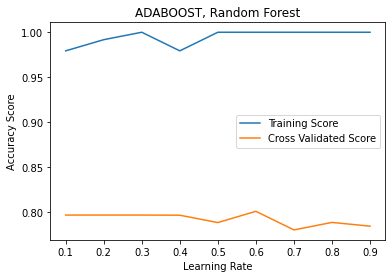

In [20]:
learning_rate = []
for i in gridAdaNoCv.cv_results_['params']:
    val = sum( i.values() ) 
    learning_rate.append(val)

Score_ADA_NoCV = gridAdaNoCv.cv_results_['mean_test_score']   
Score_ADA_wCV = gridAdaCv.cv_results_['mean_test_score']   


plt.plot(learning_rate, Score_ADA_NoCV, label = "Training Score")
plt.plot(learning_rate, Score_ADA_wCV, label = "Cross Validated Score")
plt.xlabel('Learning Rate')
# Set the y axis label of the current axis.
plt.ylabel('Accuracy Score')
# Set a title of the current axes.
plt.title('ADABOOST, Random Forest')
# show a legend on the plot
plt.legend()
plt.show()

### Model Comparison: Decision Tree, Random Forest, Adaboost

cross validated decision tree: DecisionTreeClassifier(max_depth=3, random_state=42)
 
_____cross validated training accuracy: 0.8471074380165289
_____testing accuracy: 0.8524590163934426


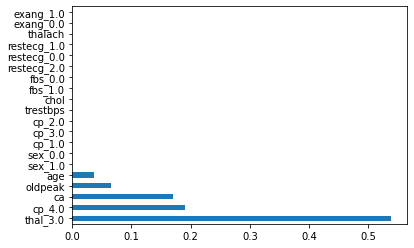

 
cross validated random forest: RandomForestClassifier(max_depth=3, random_state=42)
 
_____cross validated training accuracy: 0.8677685950413223
_____testing accuracy: 0.8524590163934426


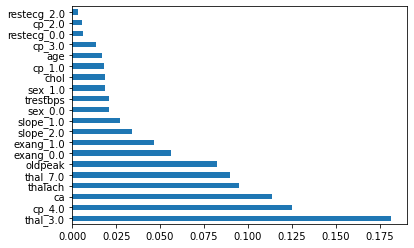

 
cross validated Adaboosted Random Forest: AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=3),
                   learning_rate=0.6, n_estimators=100, random_state=42)
 
_____cross validated training accuracy: 1.0
_____testing accuracy: 0.8852459016393442


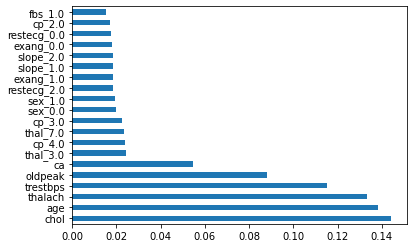

In [21]:
from sklearn.metrics import accuracy_score
%matplotlib inline

optimized_decison_tree = gridDtCv.best_estimator_
dt_training_score = accuracy_score(optimized_decison_tree.predict(X_train), y_train)
dt_test_score = accuracy_score(optimized_decison_tree.predict(X_test), y_test)

optimised_random_forest = gridRFCv.best_estimator_
rf_training_score = accuracy_score(optimised_random_forest.predict(X_train), y_train)
rf_test_score = accuracy_score(optimised_random_forest.predict(X_test), y_test)

optimised_adaboost = gridAdaCv.best_estimator_
ada_training_score = accuracy_score(optimised_adaboost.predict(X_train), y_train)
ada_test_score = accuracy_score(optimised_adaboost.predict(X_test), y_test)



print('cross validated decision tree: ' + str(optimized_decison_tree) )
print(' ')
print('_____cross validated training accuracy: ' + str(dt_training_score) )
print('_____testing accuracy: ' + str(dt_test_score) )
dt_feat_importances = pd.Series(optimized_decison_tree.feature_importances_, index=X.columns)
dt_feat_importances.nlargest(20).plot(kind='barh')
plt.show()

print(' ')
print('cross validated random forest: ' + str(optimised_random_forest) )
print(' ')
print('_____cross validated training accuracy: ' + str(rf_training_score) )
print('_____testing accuracy: ' + str(rf_test_score) )
rf_feat_importances = pd.Series(optimised_random_forest.feature_importances_, index=X.columns)
rf_feat_importances.nlargest(20).plot(kind='barh')
plt.show()

print(' ')
print('cross validated Adaboosted Random Forest: ' + str(optimised_adaboost)  )
print(' ')
print('_____cross validated training accuracy: ' + str(ada_training_score) )
print('_____testing accuracy: ' + str(ada_test_score) )
ada_feat_importances = pd.Series(optimised_adaboost.feature_importances_, index=X.columns)
ada_feat_importances.nlargest(20).plot(kind='barh')
plt.show()
